<a href="https://colab.research.google.com/github/sarkar2527/DSAP/blob/main/Sentiment_Anaylsis_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Sentiment_Analysis/Tweets.csv")

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
#We only need the text and sentiment column.
review_df = df[['text','airline_sentiment']]

print(review_df.shape)
review_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [6]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

We don’t really need neutral reviews in our dataset for this binary classification problem. So, drop those rows from the dataset.

In [7]:
review_df = review_df[review_df['airline_sentiment'] != 'neutral']

print(review_df.shape)
review_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [8]:
review_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

The labels for this dataset are categorical. Machines understand only numeric data. So, convert the categorical values to numeric using the factorize() method. This returns an array of numeric values and an Index of categories.

In [9]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

If we observe, the 0 here represents positive sentiment and the 1 represents negative sentiment.

Now, the major part in python sentiment analysis. We should transform our text data into something that our machine learning model understands. Basically, we need to convert the text into an array of vector embeddings. Word embeddings are a beautiful way of representing the relationship between the words in the text.

To do this, we first give each of the unique words a unique number and then replace that word with the number assigned.

First, retrieve all the text data from the dataset

In [10]:
tweet = review_df.text.values

Now, before proceeding ahead in python sentiment analysis project let’s tokenize all the words in the text with the help of Tokenizer. In tokenization, we break down all the words/sentences of a text into small parts called tokens.

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

The fit_on_texts() method creates an association between the words and the assigned numbers. This association is stored in the form of a dictionary in the tokenizer.word_index attribute.

Now, replace the words with their assigned numbers using the text_to_sequence() method.

In [12]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

Each of the sentences in the dataset is not of equal length. Use padding to pad the sentences to have equal length.

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

For sentiment analysis project, we use LSTM layers in the machine learning model. The architecture of our model consists of an embedding layer, an LSTM layer, and a Dense layer at the end. To avoid overfitting, we introduced the Dropout mechanism in-between the LSTM layers.

LSTM stands for Long Short Term Memory Networks. It is a variant of Recurrent Neural Networks. Recurrent Neural Networks are usually used with sequential data such as text and audio. Usually, while computing an embedding matrix, the meaning of every word and its calculations (which are called hidden states) are stored. If the reference of a word, let’s say a word is used after 100 words in a text, then all these calculations RNNs cannot store in its memory. That’s why RNNs are not capable of learning these long-term dependencies.

LSTMs on the other hand work well with such text. LSTM networks work well with time-series data.



In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [15]:
embedding_vector_length = 32
vocab_size =11541
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           369312    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 385,963
Trainable params: 385,963
Non-trainable params: 0
__________________________________________________

In [16]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 83s 276ms/step - loss: 0.3890 - accuracy: 0.8376 - val_loss: 0.2030 - val_accuracy: 0.9212
Epoch 2/5
289/289 [==============================] - 75s 261ms/step - loss: 0.2137 - accuracy: 0.9148 - val_loss: 0.1759 - val_accuracy: 0.9329
Epoch 3/5
289/289 [==============================] - 71s 245ms/step - loss: 0.1632 - accuracy: 0.9399 - val_loss: 0.1646 - val_accuracy: 0.9433
Epoch 4/5
289/289 [==============================] - 73s 251ms/step - loss: 0.1339 - accuracy: 0.9492 - val_loss: 0.1652 - val_accuracy: 0.9433
Epoch 5/5
289/289 [==============================] - 71s 246ms/step - loss: 0.1117 - accuracy: 0.9602 - val_loss: 0.2039 - val_accuracy: 0.9450


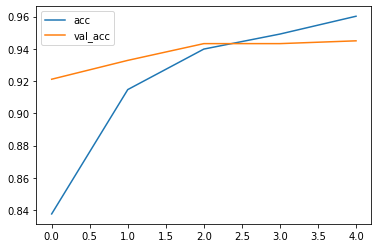

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

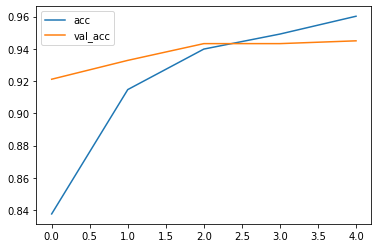

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

In [19]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])


test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

Predicted label:  positive
Predicted label:  negative


Summary
We have successfully developed python sentiment analysis model. In this machine learning project, we built a binary text classifier that classifies the sentiment of the tweets into positive and negative. We obtained more than 94% accuracy on validation.

This is an interesting project which helps businesses across the domains to understand customers sentiment / feeling towards their brands.